<a href="https://colab.research.google.com/github/bjmcnamee/test2/blob/main/Viz02_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""

    If the notebook is running in Colab, we want to download models and results
    when they are ready so they don't get lost if Colab times out.

    This global variable keeps track of that.

"""
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import files

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import BatchNormalization,LayerNormalization, Dropout

In [ ]:
"""

    Verify we are running the correct Tensorflow version

"""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
"""

    Verify that we are using a GPU runtime

    If there is no GPU found, you can activate this in the Colab settings at "Runtime => Change runtime type".
    If you are running this locally, GPU support might require setup of CUDA/CUDNN beforehand.

    It is highly recommended to use a GPU while training the CNN models.

"""
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
"""

    A helper utility to generate a pretty confusion matrix

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

"""
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar()
    plt.rcParams.update({'font.size': 18})


    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18, ha="right")
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

In [ ]:
"""

    Utility function to plot, save and download the confusion matrix

"""
def display_confusion_matrix(y_pred, y_true, target_names, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, target_names, normalize=False, save_path=save_path)

    if RunningInCOLAB and save_path:
        files.download(save_path)

"""

    Utility function to print, save and download the classification report

"""
def display_classification_report(y_pred, y_true, target_names, save_path=None):
    cr = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    df = pd.DataFrame(cr).transpose()
    df = df.round(2)

    print(df)
    
    if save_path:
        df.to_csv(save_path, sep=';')
    
    if RunningInCOLAB and save_path:
        files.download(save_path)

In [ ]:
"""

    Simple helper utility to plot training history metrics against validation

"""
def plot_history(history):

    # loss vs val_loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()

    # acc vs val_acc
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='right')
    plt.show()

In [ ]:
"""
    Copy all data to Colab from Google Drive
    - faster than copying individual files each time they are needed
    - data already split into train, validate and test folders
    - data saved to Colab 'content' folder

    Parameters that apply for all models and datagenerators
"""
from google.colab import drive
drive.mount('/content/drive')
from os import path
if not path.exists('/content/kvasir-dataset-v2'):
  # copy data from Google Drive to Google Colab for faster model training - rather than fetch file each time its needed
  %cp -av '/content/drive/MyDrive/Study/Sem2/VIZ/Ass02/kvasir-dataset-v2' '/content/kvasir-dataset-v2'

In [ ]:
train_path = '/content/kvasir-dataset-v2/train'
test_path = '/content/kvasir-dataset-v2/test'
validate_path = '/content/kvasir-dataset-v2/validate'


batch_size = 32
target_w = 200
target_h = 200
target_size = (target_w, target_h) 
target_dims = 3 # (RGB channels)

## 2 Convolutional Neural Network

### 2.1 Preprocessing

In [ ]:
"""

    Set up datagenerators for CNN model

    Datagenerators handle image augmentation (shear, zoom, horizontal flips) as well as rescaling.
    The datagenerator also has a built-in training/validation splitter, which creates a new 80/20 split.

    In addition to that, we want a separate generator with our test set.

    The dataset will be split as follows:
    - Training set (64% - 80% of 80)
    - Validation set (16% - 20% of 80)
    - Test set (20%)

"""

"""
    Datagenerator for training set
"""
cnn_train_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # If defined, will split based on 'subset' in flow_from_directory()

cnn_train_datagen = cnn_train_idg.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    subset='training') # Marks this as the training data

cnn_val_datagen = cnn_train_idg.flow_from_directory(
    validate_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # Marks this as the validation data

"""
    Datagenerator for test set
"""
cnn_test_idg = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

cnn_test_datagen = cnn_test_idg.flow_from_directory(
    test_path, 
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False)

Found 4480 images belonging to 8 classes.
Found 240 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


### 2.2 Build model

In [ ]:
"""

    Function to build a simple CNN model layer by layer

"""
def build_simple_cnn():
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(target_w, target_h, target_dims)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(8, activation='softmax'))

    model.summary()

    return model

In [ ]:
"""

    Actually build and compile the model

"""
simple_cnn = build_simple_cnn()

simple_cnn.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=[ 'accuracy' ]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                        

### 2.3 Train model

In [ ]:
"""
    Start fitting the model
"""
cnn_history = simple_cnn.fit(cnn_train_datagen, 
                        epochs=20,
                        verbose=1, 
                        validation_data=cnn_val_datagen)

simple_cnn.save('models/cnn_simple.hdf5')

if RunningInCOLAB:
    files.download('models/cnn_simple.hdf5')

Epoch 1/20
140/140 [==============================] - 108s 700ms/step - loss: 2.5416 - accuracy: 0.4234 - val_loss: 2.1977 - val_accuracy: 0.2500
Epoch 2/20
140/140 [==============================] - 98s 700ms/step - loss: 1.1761 - accuracy: 0.5696 - val_loss: 2.7603 - val_accuracy: 0.3208
Epoch 3/20
140/140 [==============================] - 98s 700ms/step - loss: 1.1825 - accuracy: 0.5739 - val_loss: 1.3225 - val_accuracy: 0.5167
Epoch 4/20
140/140 [==============================] - 98s 699ms/step - loss: 1.0220 - accuracy: 0.6107 - val_loss: 2.2853 - val_accuracy: 0.3583
Epoch 5/20
140/140 [==============================] - 97s 695ms/step - loss: 0.9990 - accuracy: 0.6047 - val_loss: 1.3657 - val_accuracy: 0.5875
Epoch 6/20
140/140 [==============================] - 97s 690ms/step - loss: 0.9335 - accuracy: 0.6348 - val_loss: 1.4050 - val_accuracy: 0.5083
Epoch 7/20
140/140 [==============================] - 97s 692ms/step - loss: 0.8850 - accuracy: 0.6377 - val_loss: 1.1566 - val_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.4 Evaluate model

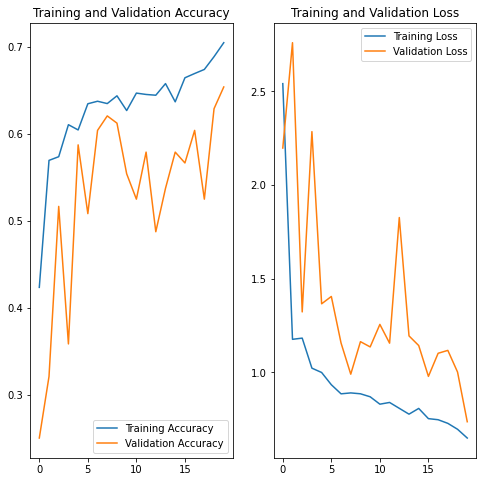

In [ ]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.models import load_model
best_model = load_model(filepath='models/cnn_simple.hdf5')
loss, acc = best_model.evaluate(cnn_val_datagen, steps=cnn_val_datagen.n//cnn_val_datagen.batch_size)

7/7 [==============================] - 5s 692ms/step - loss: 0.7235 - accuracy: 0.6786


In [ ]:
print ('Loss : ',round(loss,4), 'Accuracy : ',round(acc,4))

Loss :  0.7235 Accuracy :  0.6786


In [ ]:
"""
    Use the model to predict on the unseen test set.
"""
cnn_predictions = simple_cnn.predict(cnn_test_datagen, verbose=1)

38/38 [==============================] - 16s 436ms/step


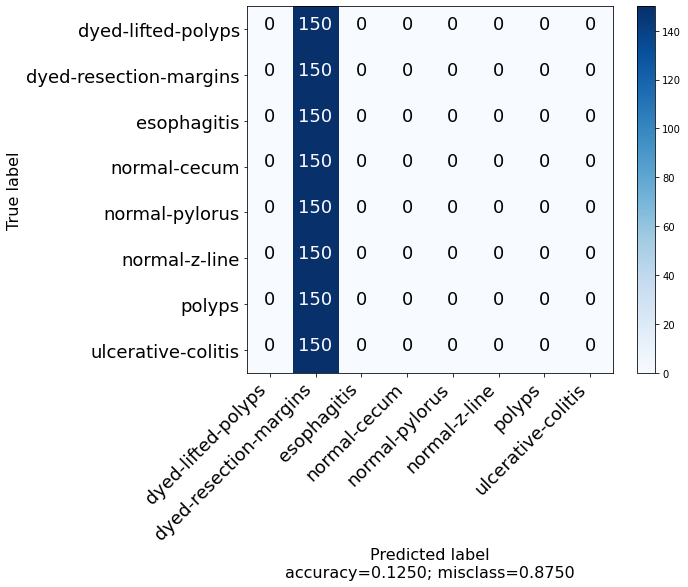

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        precision  recall  f1-score  support
dyed-lifted-polyps           0.00    0.00      0.00   150.00
dyed-resection-margins       0.12    1.00      0.22   150.00
esophagitis                  0.00    0.00      0.00   150.00
normal-cecum                 0.00    0.00      0.00   150.00
normal-pylorus               0.00    0.00      0.00   150.00
normal-z-line                0.00    0.00      0.00   150.00
polyps                       0.00    0.00      0.00   150.00
ulcerative-colitis           0.00    0.00      0.00   150.00
accuracy                     0.12    0.12      0.12     0.12
macro avg                    0.02    0.12      0.03  1200.00
weighted avg                 0.02    0.12      0.03  1200.00


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""

    Evaluate the prediction results.

    Displays a Confusion Matrix and a Classification Report.
    These are also saved to the 'results' folder.

"""
unique_labels = list(cnn_test_datagen.class_indices.keys())

y_pred = np.argmax(cnn_predictions, axis=-1)
y_true = cnn_test_datagen.classes[cnn_test_datagen.index_array]

display_confusion_matrix(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='cnn_simple_confusion_matrix.png'
)

display_classification_report(
    y_pred=y_pred, 
    y_true=y_true, 
    target_names=unique_labels, 
    save_path='cnn_simple_classification_report.csv'
)